In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import json
import os
import copy

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.dates as mdates
from matplotlib.dates import SA

from utils.fitting.util import get_ensemble_params
from scripts.seir.combine_multiple_runs import combine_multiple_runs
from utils.fitting.util import create_output

In [4]:
outputs_dir = '/Users/avtansht/Desktop/Desktop/Wadhwani/athena'

In [5]:
def create_run_ledger(outputs_dir):
    run_ledger = pd.DataFrame(columns=['run', 'start_date', 'seed'])

    for i, run in enumerate(os.listdir(outputs_dir)):
        if run[0] == '.':
            continue
        json_file = f'{outputs_dir}/{run}/config.json'
        with open(json_file) as f:
            config = json.load(f)
        start_date = config['fitting']['split']['start_date']
        seed = config['fitting']['optimiser_params']['seed']
        run_ledger.loc[i, :] = [run, start_date, seed]
        
    return run_ledger

In [6]:
def calculate_ess(run_ledger, outputs_dir,use_beta = True):
    for i, run in enumerate(run_ledger['run']):
        if use_beta :
            beta = np.load(f'{outputs_dir}/{run}/beta.npy')
        else:
            beta = 0
        trials_params = np.load(f'{outputs_dir}/{run}/trials_params.npy', allow_pickle=True)
        trials_losses = np.load(f'{outputs_dir}/{run}/trials_losses.npy', allow_pickle=True)

        loss_wt = np.exp(-beta*trials_losses)
        loss_wt = loss_wt / np.sum(loss_wt)
        ess = 1/np.sum(loss_wt**2)

        run_ledger.loc[i, 'ess'] = round(ess, 0)
        run_ledger.loc[i, 'beta'] = beta

    return run_ledger

In [21]:
import arviz as az
def _calculate_ensemble_params(run_ledger, outputs_dir,use_beta = True,use_hpdi =False):
    df_params_master = copy.deepcopy(run_ledger)
    df_params_master.columns = pd.MultiIndex.from_arrays([df_params_master.columns, ['']*len(df_params_master.columns)])

    for i, run in enumerate(os.listdir(outputs_dir)):
        if run[0] == '.':
            continue
        idx = df_params_master[df_params_master['run'] == run].index[0]

        if use_beta :
            beta = np.load(f'{outputs_dir}/{run}/beta.npy')
        else:
            beta = 0
        trials_params = np.load(f'{outputs_dir}/{run}/trials_params.npy', allow_pickle=True)
        trials_losses = np.load(f'{outputs_dir}/{run}/trials_losses.npy', allow_pickle=True)
        params_dict = {param: [param_dict[param] for param_dict in trials_params]
                   for param in list(trials_params[0].keys())}
        em_params, em_params_dev = get_ensemble_params(trials_params, trials_losses, beta, return_dev=True)
        list_of_params = list(em_params.keys())
        for param in list(em_params.keys()):
            df_params_master.loc[idx, (param, 'mean')] = em_params[param]
            if use_hpdi:
                l,u = az.hdi(np.array(params_dict[param]),0.95)
                df_params_master.loc[idx, (param, 'bound_l')] = l
                df_params_master.loc[idx, (param, 'bound_u')] = u
                df_params_master.loc[idx, (param, 'std_err')] = em_params_dev[param]/np.sqrt(df_params_master.loc[idx, ('ess', '')])
            else:
                df_params_master.loc[idx, (param, 'std_err')] = em_params_dev[param]/np.sqrt(df_params_master.loc[idx, ('ess', '')])

    df_params_master[('start_date', '')] = pd.to_datetime(df_params_master[('start_date', '')], format='%Y-%m-%d')
    df_params_master.columns = df_params_master.columns.map('_'.join)
    df_params_master.columns = [x if x[-1] != '_' else x[:-1] for x in df_params_master.columns]
    
    return df_params_master,list_of_params

In [22]:
run_ledger = create_run_ledger(outputs_dir)
run_ledger = calculate_ess(run_ledger, outputs_dir,use_beta = False)
run_ledger

,run,start_date,seed,ess,beta
0,135,2020-05-28,100,2000.0,0.0
1,307,2020-07-01,300,2000.0,0.0
2,763,2020-09-30,400,2000.0,0.0
3,551,2020-08-19,200,2000.0,0.0
4,61,2020-05-13,200,2000.0,0.0
...,...,...,...,...,...
767,185,2020-06-07,100,2000.0,0.0
768,718,2020-09-21,400,2000.0,0.0
769,25,2020-05-06,100,2000.0,0.0
770,388,2020-07-17,400,NaN,NaN


In [23]:
df_params_master,list_of_params = _calculate_ensemble_params(run_ledger, outputs_dir,use_beta = False,use_hpdi=True)
df_params_master.sort_values('start_date')

,run,start_date,seed,ess,beta,E_hosp_ratio_mean,E_hosp_ratio_bound_l,E_hosp_ratio_bound_u,E_hosp_ratio_std_err,I_hosp_ratio_mean,...,T_recov_bound_u,T_recov_std_err,T_recov_fatal_mean,T_recov_fatal_bound_l,T_recov_fatal_bound_u,T_recov_fatal_std_err,lockdown_R0_mean,lockdown_R0_bound_l,lockdown_R0_bound_u,lockdown_R0_std_err
281,0,2020-05-01,100,2000.0,0.0,1.222292,0.615151,1.880941,0.007217,0.219582,...,31.616012,0.112540,14.327069,2.489607,24.694968,0.127384,1.007489,0.853428,1.199976,0.002211
705,3,2020-05-01,400,2000.0,0.0,0.960384,0.439380,1.706508,0.006725,0.293973,...,31.707765,0.112214,16.115472,2.108118,26.339105,0.136564,1.086417,0.851819,1.200000,0.002450
341,1,2020-05-01,200,2000.0,0.0,0.810835,0.139659,1.450100,0.007096,0.292099,...,31.575030,0.111243,16.200899,1.586980,27.326578,0.147832,1.124137,0.911409,1.200000,0.002025
700,4,2020-05-01,500,2000.0,0.0,0.805704,0.174644,1.364052,0.006358,0.326306,...,30.903391,0.110853,18.078886,5.617942,31.910138,0.141094,1.103534,0.849727,1.199997,0.002416
744,2,2020-05-01,300,2000.0,0.0,0.913461,0.348323,1.591298,0.006548,0.270825,...,30.522879,0.110672,15.801963,4.688520,28.359441,0.134891,1.096955,0.885823,1.199993,0.002241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486,768,2020-10-01,400,2000.0,0.0,0.355550,0.000025,1.109789,0.007592,0.458905,...,21.517183,0.126686,15.756768,3.198657,31.393545,0.149141,0.800361,0.700001,1.000990,0.002022
73,765,2020-10-01,100,2000.0,0.0,0.287830,0.000003,1.189274,0.008460,0.511464,...,21.656654,0.128140,28.152786,14.700589,39.996196,0.164271,0.848787,0.700216,0.990971,0.001865
415,767,2020-10-01,300,2000.0,0.0,0.311359,0.000017,1.134871,0.007921,0.506784,...,21.592591,0.128465,25.594809,10.863691,39.999153,0.170565,0.811467,0.700005,0.984589,0.001878
497,766,2020-10-01,200,2000.0,0.0,0.287458,0.000029,1.211611,0.008395,0.478736,...,21.476069,0.126899,24.115193,14.206922,39.998330,0.142475,0.875991,0.700023,1.032022,0.001959


In [24]:
df_params_comb = df_params_master.groupby('start_date').mean()
df_params_comb.reset_index(inplace=True)

In [25]:
df_params_comb

,start_date,ess,beta,E_hosp_ratio_mean,E_hosp_ratio_bound_l,E_hosp_ratio_bound_u,E_hosp_ratio_std_err,I_hosp_ratio_mean,I_hosp_ratio_bound_l,I_hosp_ratio_bound_u,...,T_recov_bound_u,T_recov_std_err,T_recov_fatal_mean,T_recov_fatal_bound_l,T_recov_fatal_bound_u,T_recov_fatal_std_err,lockdown_R0_mean,lockdown_R0_bound_l,lockdown_R0_bound_u,lockdown_R0_std_err
0,2020-05-01,2000.0,0.0,0.942535,0.343431,1.598580,0.006789,0.280557,0.000046,0.611425,...,31.265015,0.111505,16.104858,3.298233,27.726046,0.137553,1.083706,0.870441,1.199993,0.002268
1,2020-05-02,2000.0,0.0,0.994261,0.363229,1.596213,0.006552,0.243573,0.000043,0.589721,...,30.846801,0.110947,17.177265,5.117925,28.546742,0.122435,1.063932,0.860518,1.185212,0.002111
2,2020-05-03,2000.0,0.0,0.938984,0.343389,1.561459,0.006492,0.240270,0.000137,0.570029,...,30.560864,0.111504,17.323179,4.621334,28.746676,0.133611,1.082917,0.871726,1.199997,0.002293
3,2020-05-04,2000.0,0.0,0.988316,0.342454,1.591751,0.006710,0.214152,0.000039,0.596804,...,29.728422,0.110136,15.452728,3.286733,28.102782,0.136098,1.092665,0.876042,1.199995,0.002285
4,2020-05-05,2000.0,0.0,1.064324,0.375815,1.624831,0.006504,0.189546,0.000021,0.598251,...,29.488452,0.111010,15.639932,2.895454,28.811056,0.150703,1.110497,0.893736,1.199988,0.002151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,2020-09-27,2000.0,0.0,0.360563,0.000023,1.123646,0.007679,0.454643,0.131087,0.748307,...,21.815350,0.125716,23.735840,7.948010,37.094282,0.173842,0.802879,0.700009,1.039093,0.002259
150,2020-09-28,2000.0,0.0,0.330996,0.000015,1.148943,0.007992,0.485528,0.139153,0.758847,...,21.623552,0.126736,26.987139,12.064693,38.489670,0.163523,0.814373,0.700019,1.036538,0.002267
151,2020-09-29,2000.0,0.0,0.308072,0.000016,1.157073,0.008066,0.495172,0.143410,0.765755,...,21.550674,0.127512,25.219373,11.660353,38.277233,0.157375,0.829358,0.700050,1.007352,0.001961
152,2020-09-30,2000.0,0.0,0.308072,0.000016,1.157073,0.008066,0.495172,0.143410,0.765755,...,21.550674,0.127512,25.219373,11.660353,38.277233,0.157375,0.829358,0.700050,1.007352,0.001961


# KDE Plot

In [26]:
# fig, axs = plt.subplots(figsize=(16, 21), nrows=4, ncols=2)
# for i, param in enumerate(list_of_params):
#     ax = axs.flat[i]
#     sns.kdeplot(data=df_params, y=param, weights='loss_wt', ax=ax)

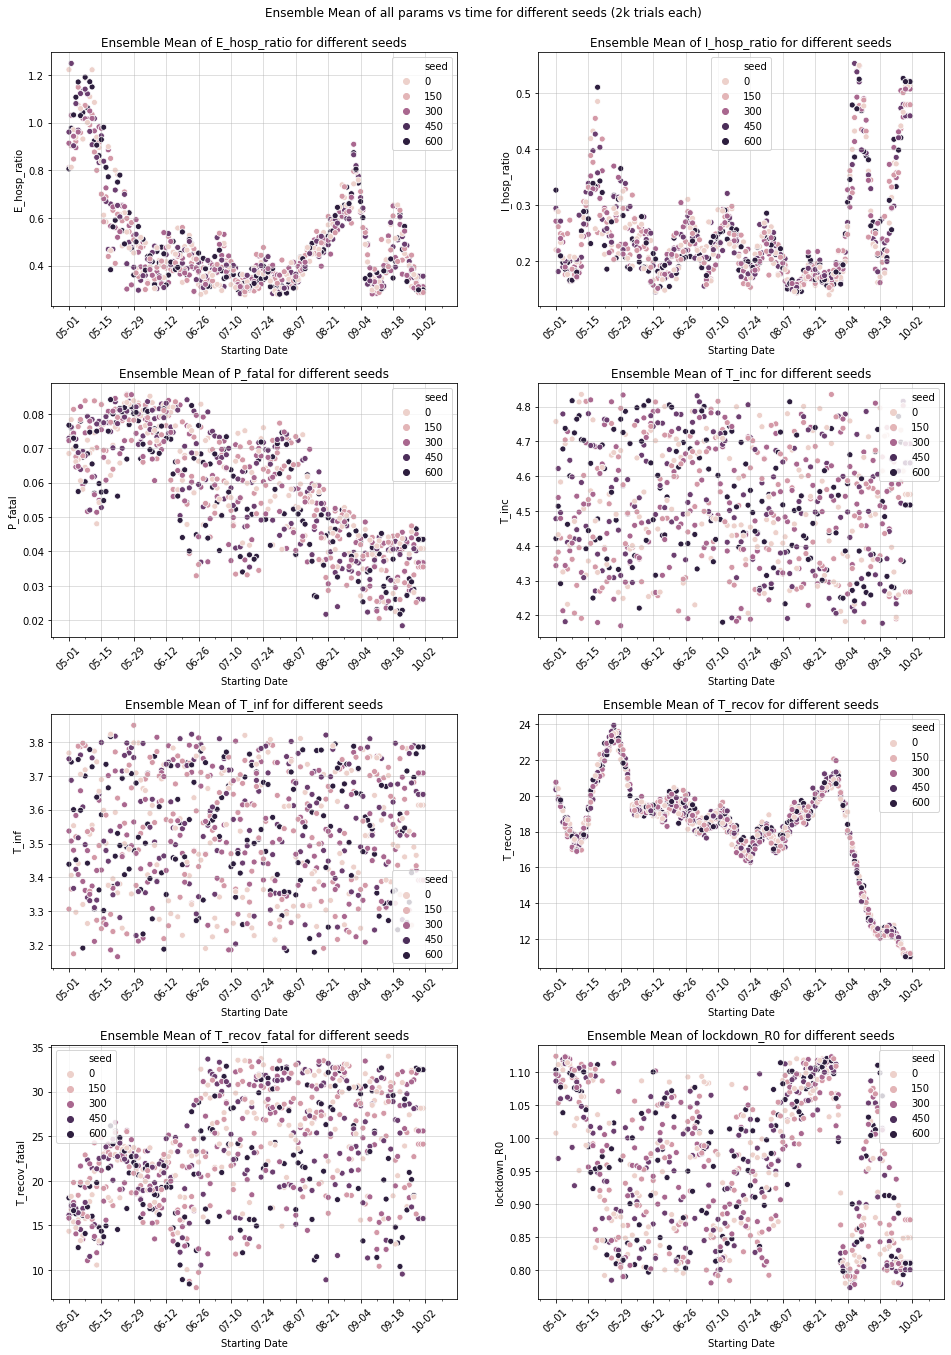

In [27]:
fig, axs = plt.subplots(figsize=(16, 21), nrows=4, ncols=2)
for i, param in enumerate(list_of_params):
    ax = axs.flat[i]
    sns.scatterplot(data=df_params_master, x='start_date', y=f'{param}_mean', hue='seed', ax=ax)
    ax.set_title(f'Ensemble Mean of {param} for different seeds')
    ax.set_ylabel(param)
    ax.set_xlabel('Starting Date')
    
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=7))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.tick_params('x', labelrotation=45)
    ax.grid(alpha=0.5)
    
    ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1]+7)
    
fig.suptitle(f'Ensemble Mean of all params vs time for different seeds (2k trials each)')
fig.subplots_adjust(top=0.95, hspace=0.3)

In [28]:
fig.savefig('em-mean-params-diff-seeds.png')

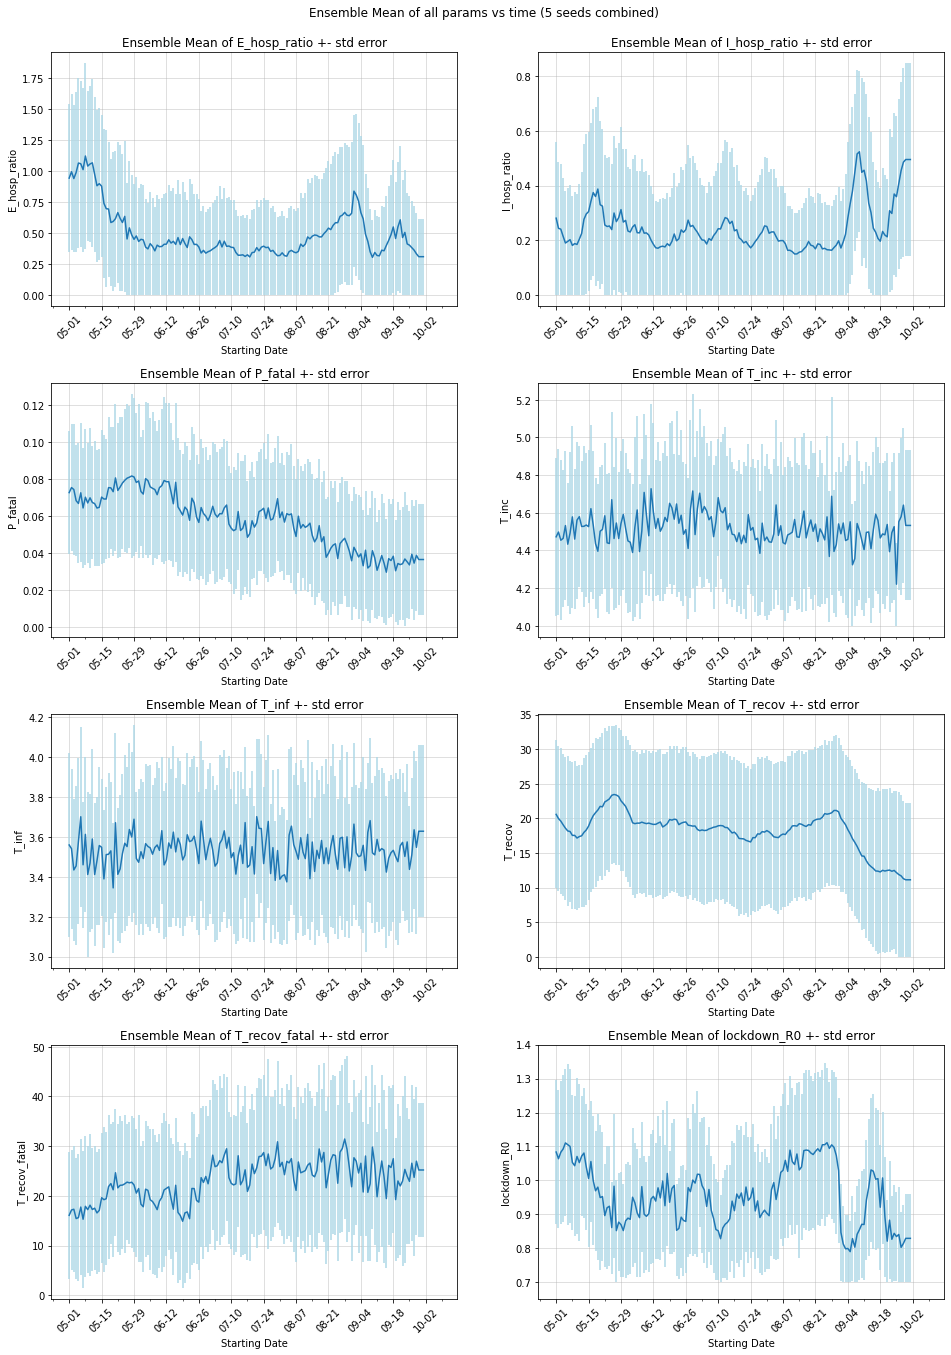

In [31]:
fig, axs = plt.subplots(figsize=(16, 21), nrows=4, ncols=2)
use_hpdi =True
for i, param in enumerate(list_of_params):
    ax = axs.flat[i]
    if use_hpdi:
        ax.errorbar(x=df_params_comb['start_date'], y=df_params_comb[f'{param}_mean'], yerr=np.array(df_params_comb[f'{param}_mean']-df_params_comb[f'{param}_bound_l'],df_params_comb[f'{param}_bound_u']-df_params_comb[f'{param}_mean']),ecolor = 'lightblue')
    else:
        ax.errorbar(x=df_params_comb['start_date'], y=df_params_comb[f'{param}_mean'].rolling(window = 4).mean(), yerr=df_params_comb[f'{param}_std_err'])
    ax.set_title(f'Ensemble Mean of {param} +- std error')
    ax.set_ylabel(param)
    ax.set_xlabel('Starting Date')
    if param == 'lockdown_R0':
        ax.set_ylim(.65,1.4)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=7))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.tick_params('x', labelrotation=45)
    ax.grid(alpha=0.5)
    
    ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1]+7)
    
fig.suptitle(f'Ensemble Mean of all params vs time (5 seeds combined)')
fig.subplots_adjust(top=0.95, hspace=0.3)

In [24]:
fig.savefig('em-mean-params-std-error-v1.png')rolling

In [25]:
np.savetxt('../../configs/exper/runs.txt', run_ledger['run'].to_numpy().reshape((-1, 5)).astype(int), fmt='%d')

ValueError: cannot reshape array of size 771 into shape (5)

In [ ]:
np.loadtxt('../../configs/exper/runs.txt', dtype='int', delimiter=' ').tolist()